# 설정
먼저 몇 개의 모듈을 임포트 한다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비한다. 또한 파이썬 버전이 3.5 이상인지 확인한다.

In [4]:
# 파이썬 >= 3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 >= 0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래픽 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok = True)

def save_fig(fig_id, tight_layout=True, fig_extension = "png", resolution = 300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extension, dpi = resolution)


## 3.1 MNIST

In [5]:
# MNIST 데이터 내려받기

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
# 살펴보기

X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

70000 개의 이미지가 있고 각 이미지에는 784개의 특성(이미지가 28x28 픽셀이기 떄문에)이 있다는 의미
이때 특성이란 단순히 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타낸다.

In [7]:
y.shape

(70000,)

In [8]:
28*28

784

그림 저장: some_digit_plot


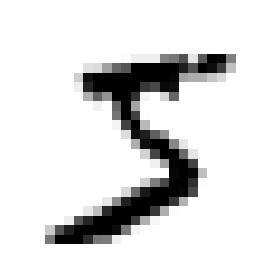

In [9]:
# 데이터셋에서 이미지 하나를 확인해 보기
# 샘플의 특성 벡터를 추출해서 28*28 배열로 크기를 바꾸고 맷플롯립의 imshow( )함수로 그려본다.

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [10]:
# 위 그림의 레이블 확인해 보기

y[0]

'5'

In [12]:
# 레이블은 문자열이다.
# 머신러닝 알고리즘에서는 숫자가 기대하므로 정수로 변환해 준다.

y = y.astype(np.uint8)

In [13]:
# MNIST 데이터셋에 들어 있는 다른 숫자이미지들도 출력해 보자

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
                interpolation = "nearest")
    plt.axis("off")

In [14]:
# 숫자 그림을 위한 추가 함수
# 이해못함

def plot_digits(instances, images_per_row = 10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis = 1))
    image = np.concatenate(row_images, axis = 0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

그림 저장: more_digits_plot


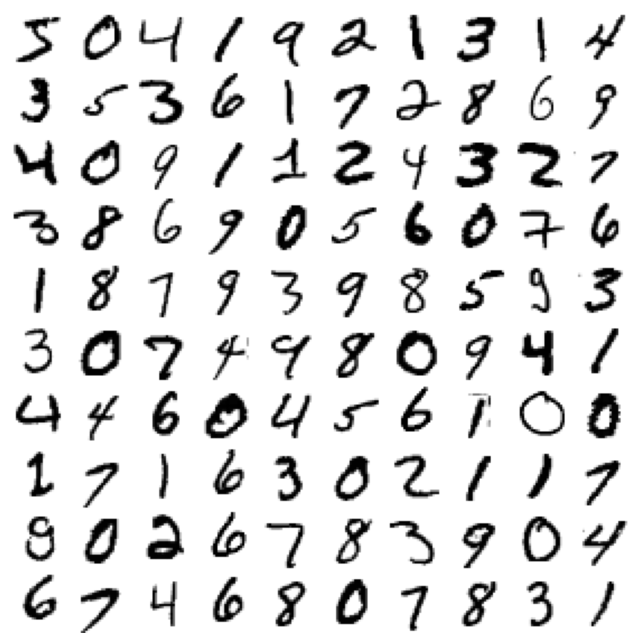

In [15]:
plt.figure(figsize = (9, 9))
example_images = X[:100]
plot_digits(example_images, images_per_row = 10)
save_fig("more_digits_plot")
plt.show()

In [16]:
# MNIST 데이터셋은 훈련세트와 테스트세트가 이미 나누어져 있다.

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련

In [17]:
# 분류 작업을 위해 타깃 벡터를 만든다.

y_train_5 = (y_train == 5) # <- 5는 True고 나머지는 False
y_test_5 = (y_test == 5)

In [18]:
# SGDClassifier 모델을 만들고 전체 훈련 세트를 사용해 훈련시켜 보자.

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter = 1000, tol = 1e-3, random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

이렇게 fit 메서드로 이제 타겟값 5를 가지는~데이터들로 훈련된 모델을 만든 것?  
이렇게 만든 모델로 이제 예측을 하는 거지 !

In [19]:
# 이전에 만들어둔 숫자5 이미지 변수 감지해보기

sgd_clf.predict([some_digit])

array([ True])

분류기는 이 이미지가 5를 나타낸다고 추측했다는 의미 "True"

## 3.3 성능 측정
### 교차 검증을 사용한 정확도 측정

In [20]:
# cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델을 평가해 보자.
# 이때 k-겹 교차 검증은 훈련세트를 k개의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용한다는 것을 기억하자.

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

출력 결과를 보면 모두 95% 이상의 높은 정확도를 보이는 것을 알 수 있다.

In [21]:
# 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교해 보자.

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [22]:
# 모델의 정확도 추측해 보기

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

출력해 보면 마찬가지로 높은 정확도를 띈다.  
애초에 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님' 으로 예측하면 정확히 맞출 확률이 90% 다.  
이처럼 불균형한 데이터셋 (어떤 클래스가 다른 것보다 월등히 많은 경우)을 다룰 때는 정확도는 분류기의 성능 측정 지표로 선호되지 않는다.  

### 오차 행렬

In [16]:
# 오차 행렬을 만들려면 실제 타깃과 비교할 예측값이 필요한데 이때 테스트 세트로 예측값을 만드는 것이 아니라
# cross_val_predict() 메서드를 사용한다.
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
# cross_val_predict()는 교차 검증을 수행하고 각 테스트 폴드에서 얻은 예측을 반환한다.
# 즉 훈련 세트의 모든 샘플에 대한 예측을 얻게 된다.

In [17]:
# 오차 행렬 만들기

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [18]:
# 완벽한 분류기인 경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

# 전부 진짜 양성 아님 음성에만 해당

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### 정밀도와 재현율

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)
# 정밀도
# 즉 5로 판별된 이미지중 83.7%만 정확하구나 !

0.8370879772350012

In [20]:
cm = confusion_matrix(y_train_5, y_train_pred)  # 오차 행렬을 만들고
cm[1, 1] / (cm[0, 1] + cm[1, 1])  # 직접 숫자를 대입해서 계산해보니 위의 메서드로 한 값과 동일 !

0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred)  # 정답과 예측값을 넣어주면 알아서 계산이 된다?
# 재현율
# 즉 전체 숫자 5에서 65.1%만 감지했구나 !

0.6511713705958311

In [22]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

In [23]:
# 정밀도와 재현율의 조화평균인 F1 점수

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [24]:
# 사이킷런에서 임곗값을 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있다.
# predict() 대신 decision_function()을 호출하면 각 샘플의 점수를 얻을 수 있다.
# 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있다.
y_scores = sgd_clf.decision_function([some_digit])
y_scores  

array([2164.22030239])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred 

# 임곗값이 0이기 때문에 위 코드는 predict() 메서드와 같은 결과 True 를 반환한다.
# 즉 predict()도 0보다 큰 경우를 양성을 예측하는 구나 ~
# 아래에서는 임곗값을 높게 설정해서 해보자

array([ True])

In [26]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

# 임곗값을 높이면 재현율이 줄어드는 것을 결과로 확인할 수 있다 ?
# "이미지가 실제로 숫자 5이고 임곗값이 0일 때는 분류기가 이를 감지했지만, 임곗값을 높이면 놓치게 된다"

array([False])

In [27]:
# 적절한 임곗값을 찾으려면 cross_val_predict() 로 훈련 세트에 있는 모든 샘플의 점수를 구해야 한다.
# 이때 예측 결과가 아니라 결정 점수를 반환 받는다.
# 이 점수로 precision_recall_curve() 함수를 사용하여 가능한 모든 임곗값에 대한 정밀도와 재현율을 계산할 수 있다.

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

In [28]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# 이제 맷플롯립으로 임곗값의 함수로 정밀도와 재현율을 그려보자.

그림 저장: precision_recall_vs_threshold_plot


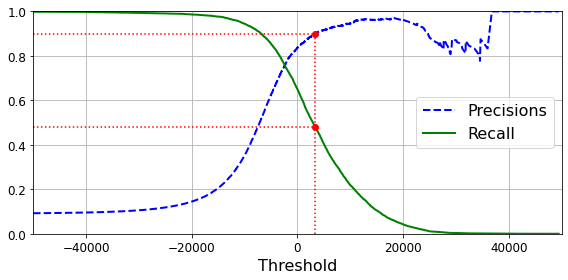

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precisions", linewidth = 2)
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall", linewidth = 2)
    plt.legend(loc = "center right", fontsize = 16)
    plt.xlabel("Threshold", fontsize = 16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize = (8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
save_fig("precision_recall_vs_threshold_plot")
plt.show()

그림 저장: precision_vs_recall_plot


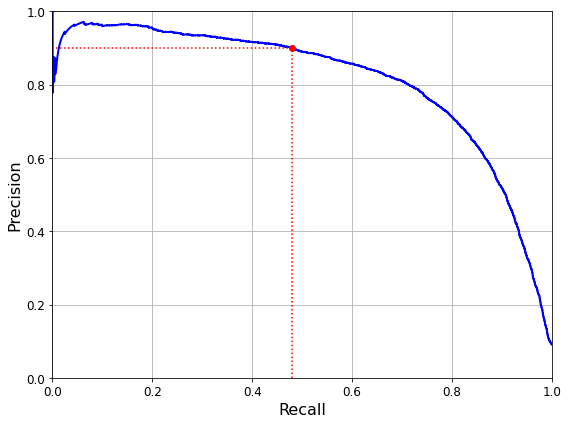

In [30]:
# 좋은 정밀도/재현율 트레이드오프를 선택하는 방법은 재현율에 대한 정밀도 곡선 그래프를 그려보는 것 
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth = 2)
    plt.xlabel("Recall", fontsize = 16)
    plt.ylabel("Precision", fontsize = 16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize = (8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

# 아래의 그래프를 보면 재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작한다.
# 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다.

In [31]:
# 최소한 90% 정밀도가 되는 가장 낮은 임계값을 찾아보자
# np.argmax()는 최댓값의 첫 번째 인덱스를 반환한다.
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [32]:
# 훈련 세트에 대한 예측을 만들려면 분류기의 predict()메서드 대신 아래의 코드를 실행한다.
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [33]:
# 위의 예측에 대한 정밀도와 재현율을 확인해 보자
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [34]:
recall_score(y_train_5, y_train_pred_90)

# 이렇게 정밀도 90% 를 달성한 분류기를 만들었다.
# 이렇게 어떤 가상의 정밀도에 대해서도 분류기를 손쉽게 만들 수 있다.

0.4799852425751706

### ROC 곡선

In [35]:
# roc_curve()함수로 여러 임곗값에서 TPR과 FRP를 계산할 수 있다.

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그림 저장: roc_curve_plot


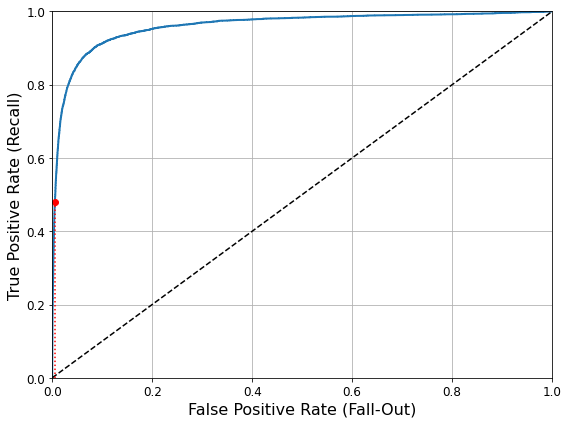

In [37]:
# TPR에 대한 FPR 곡선을 그려보자

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0 ,1], 'k--')  # 대각 점선
    plt.axis([0, 1, 0, 1])  # 축의 범위 지정
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize = 16)  # 축 이름
    plt.ylabel('True Positive Rate (Recall)', fontsize = 16)
    plt.grid(True)  # 그리드 추가

plt.figure(figsize = (8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
save_fig("roc_curve_plot")
plt.show()

# 출력된 그래프에서 점선은 완전한 랜덤 분류기의 ROC 곡선을 나타낸다.
# 좋은 분류기는 이 점선에서 최대한 멀리 떨어져야 한다.

In [38]:
# 사이킷런의 ROC의 AUC를 계산하는 함수

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [41]:
# RandomForestClassifier 를 훈련시켜서 SGDClassifier의 ROC 곡선과 ROC AUC 점수를 비교해 보자.
# 먼저 훈련세트의 샘플에 대한 점수를 알아야 한다.
# predict_proba()메서드를 이용한다.
# predict_proba()메서드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환한다.

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, 
                                    method = "predict_proba")

In [42]:
y_scores_forest = y_probas_forest[:, 1]  # 점수 대신 양성 클래스의 확률을 넣어준다.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

그림 저장: roc_curve_comparison_plot


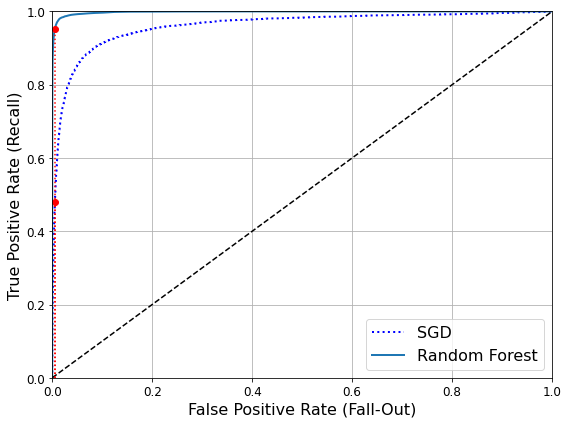

In [46]:
# 이제 ROC 곡선을 그려보자.

recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, "b:", linewidth = 2, label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc = "lower right", fontsize = 16)
save_fig("roc_curve_comparison_plot")
plt.show()

# 나타난 그래프를 보면 RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까우며 SGDClassifier 보다 좋아 보인다.
# 당연히 ROC AUC 점수도 훨씬 높다.

In [47]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [48]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)
precision_score(y_train_5, y_train_pred_forest)

# 99% 의 정밀도 !

0.9905083315756169

In [49]:
recall_score(y_train_5, y_train_pred_forest)

# 86.6%의 재현율 !

# 이진분류기를 훈련시키는 방법과 작업에 맞는 적절한 지표 선택, 교차 검증을 사용한 평가, 요구 사항에 맞는 정밀도/재현율 트레이드오프 선택, ROC곡선과 ROC AUC 점수를 사용한 여러 모델의 비교해 대해 알아봤다.

0.8662608374838591

In [50]:
# 서포트 벡터 머신 분류기 테스트해 보기

from sklearn.svm import SVC
svm_clf = SVC(gamma = "auto", random_state = 42)
svm_clf.fit(X_train[:1000], y_train[:1000])  # 0에서 9까지의 원래 타깃클래스(y_train)으로 SVC를 훈련
svm_clf.predict([some_digit])  # 훈련했으니 이제 그걸고 예측하기

array([5], dtype=uint8)

In [51]:
# decision_function() 는 샘플 당 10개의 점수(0~9니까)를 반환한다.
# 각 점수는 클래스마다 하나씩

some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

# 결과를 보면 클래스 5 의 점수가 가장 높다. 

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [52]:
np.argmax(some_digit_scores)

# np.argmax 는 인자로 받은 배열에서 최댓값의 인덱스를 반환한다.

5

In [53]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [54]:
svm_clf.classes_[5]

# classes 배열에 있는 각 클래스의 인덱스가 클래스 값 자체와 같다. <- 근데 이런 경우는 드물다.

5

In [55]:
# SVC 기반으로 OvR 전략을 사용하려는 경우

from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma = "auto", random_state = 42))
ovr_clf.fit(X_train[:1000], y_train[:1000])  # 훈련 시키고~
ovr_clf.predict([some_digit])  # 예측해야지

array([5], dtype=uint8)

In [56]:
len(ovr_clf.estimators_)

10

In [57]:
# 이번엔 SGDClassifier를 훈련시켜 보자

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

# SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 떄문에 별도로 OvR 이나 OvO 를 적용할 필요가 없다.
# decision_function()을 통해 SGD 분류기가 클래스마다 부여한 점수를 확인해 보자.

array([3], dtype=uint8)

In [58]:
sgd_clf.decision_function([some_digit])

# 클래스 3의 점수가 가장 높다.
# 위코드의 출력에서 [3] 이 나왔듯 .!

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [59]:
# 교차검증으로 분류기를 평가해 보자

cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")  # 분류기 자체, 훈련 데이터?, 타깃 데이터, 폴드 갯수 등 인자로 넣어주기

# 결과를 보니 모든 테스트 폴드에서 84% 이상을 받았다. 점수가 나쁘지는 않지만 성능을 더 높일 여지는 있다.
# 예를들어 간단하게 입력의 스케일을 조정해서 정확도를 높여보자

array([0.87365, 0.85835, 0.8689 ])

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

# 성능이 전부 89 이상이 된 것을 확인할 수 있다.

array([0.8983, 0.891 , 0.9018])